# 09: Direct Sliding-Window Forecasting (Single Category)

In this notebook we will:

1. Load our model-ready daily data  
2. Pick a high-volume category for demonstration  
3. Build sliding-window (L→H) training data  
4. Train a 1-day-ahead LightGBM model  
5. Evaluate and plot actual vs. predicted  

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error

# Load model-ready features + target
FEATURE_PATH = "data/daily_dataset/daily_df_imputed.parquet"
df = pd.read_parquet(FEATURE_PATH)
df["dt"] = pd.to_datetime(df["dt"])
print("Loaded model-ready DF:", df.shape)

Loaded model-ready DF: (4500000, 17)


In [21]:
# Compute total sales per category to pick the highest
total_sales = (
    df.groupby("third_category_id")["daily_sale_imputed"]
      .sum()
      .sort_values(ascending=False)
)
cat_id = int(total_sales.index[0])
print(f"▶️ Picking top category by volume: {cat_id}")

# Filter to just that category and set index
df_cat = (
    df[df["third_category_id"] == cat_id]
      .sort_values("dt")
      .set_index("dt")
)
print("Category DF shape:", df_cat.shape)

▶️ Picking top category by volume: 184
Category DF shape: (32940, 16)


In [22]:
def make_sliding_windows(series, L=14, H=1, exog=None):
    """
    series : pd.Series indexed by date
    exog   : pd.DataFrame of same index (or None)
    returns X (n_samples×L), y (n_samples×H), [X_exog, y_exog]
    """
    y_vals = series.values
    exog_vals = exog.values if exog is not None else None
    X, y = [], []
    for start in range(len(y_vals) - L - H + 1):
        X.append(y_vals[start : start + L])
        y.append(y_vals[start + L : start + L + H])
    X = np.stack(X)
    y = np.stack(y)
    if exog_vals is not None:
        X_exog, y_exog = [], []
        for start in range(len(exog_vals) - L - H + 1):
            X_exog.append(exog_vals[start : start + L])
            y_exog.append(exog_vals[start + L : start + L + H])
        return X, y, np.stack(X_exog), np.stack(y_exog)
    return X, y

# Prepare inputs
y_series = df_cat["daily_sale_imputed"]
exog_df  = df_cat.drop(columns="daily_sale_imputed")

# Build windows L=28 days → H=1 day ahead
L, H = 28, 1
X, y = make_sliding_windows(y_series, L=L, H=H, exog=None)
print(f"X shape: {X.shape}, y shape: {y.shape}")

X shape: (32912, 28), y shape: (32912, 1)


In [23]:
# 80/20 split on windows
split = int(0.8 * len(X))
X_train, X_val = X[:split], X[split:]
y_train, y_val = y[:split, 0], y[split:, 0]  # H=1

# Fit a simple LightGBM regressor
model = LGBMRegressor(
    n_estimators   = 200,
    learning_rate = 0.05,
    random_state  = 42
)
model.fit(X_train, y_train)

# Predict & evaluate
preds = model.predict(X_val)
rmse  = np.sqrt(mean_squared_error(y_val, preds))
print(f"🔹 Category {cat_id} — Direct 1-day RMSE: {rmse:.3f}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004325 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7140
[LightGBM] [Info] Number of data points in the train set: 26329, number of used features: 28
[LightGBM] [Info] Start training from score 12.859349
🔹 Category 184 — Direct 1-day RMSE: 17.177


/Users/jhilmitasri/Repositories/MyRepositories/freshretail-demand-forecasting/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


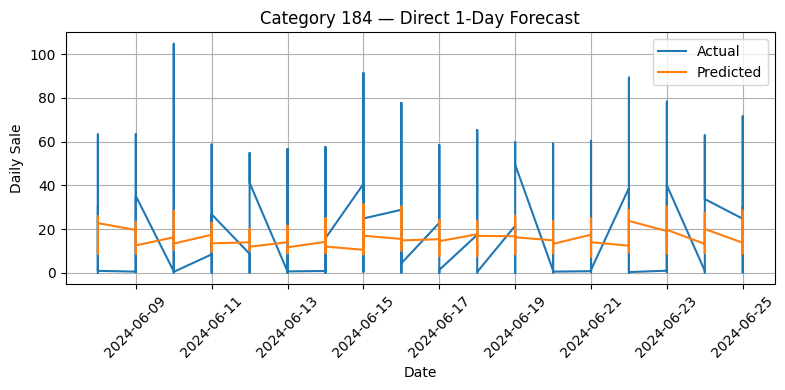

In [24]:
# Reconstruct validation dates
val_start = df_cat.index[L + split]
val_dates = df_cat.index[L + split : L + split + len(preds)]

plt.figure(figsize=(8,4))
plt.plot(val_dates, y_val, label='Actual')
plt.plot(val_dates, preds, label='Predicted')
plt.title(f"Category {cat_id} — Direct 1-Day Forecast")
plt.xlabel("Date")
plt.ylabel("Daily Sale")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

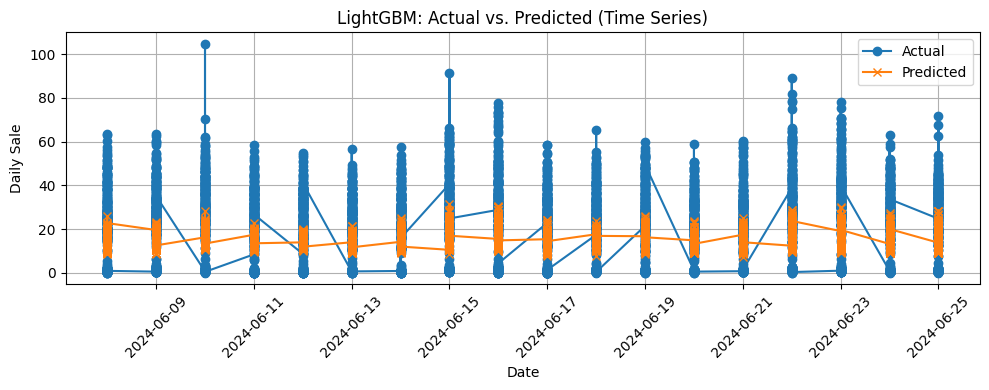

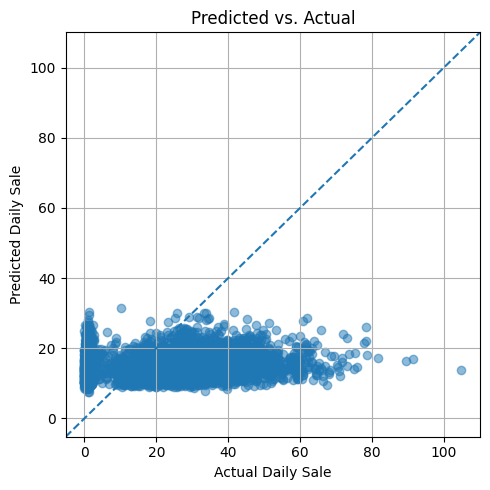

In [25]:
import numpy as np
import matplotlib.pyplot as plt

# --- 1) Time-Series Line Plot ---
plt.figure(figsize=(10,4))
plt.plot(val_dates, y_val, label='Actual', linestyle='-', marker='o')
plt.plot(val_dates, preds,  label='Predicted', linestyle='-', marker='x')
plt.title('LightGBM: Actual vs. Predicted (Time Series)')
plt.xlabel('Date')
plt.ylabel('Daily Sale')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- 2) Predicted vs. Actual Scatter ---
plt.figure(figsize=(5,5))
plt.scatter(y_val, preds, alpha=0.5)
# identity line
lims = [
    np.min([plt.xlim(), plt.ylim()]),  # min of both axes
    np.max([plt.xlim(), plt.ylim()]),  # max of both axes
]
plt.plot(lims, lims, linestyle='--')
plt.xlim(lims)
plt.ylim(lims)
plt.xlabel('Actual Daily Sale')
plt.ylabel('Predicted Daily Sale')
plt.title('Predicted vs. Actual')
plt.grid(True)
plt.tight_layout()
plt.show()